Partie IA

Imports

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import plotly.express as px
from IPython.display import display, HTML
import warnings
from colorama import Fore, Style

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, roc_auc_score
from scipy.stats import randint
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings('ignore')


In [2]:
df_tr = pd.read_csv(r'C:\Users\colin\Documents\ESEO\E5\docsPFE\creditcard_2023.csv')

In [3]:
from IPython.display import display, HTML

def styled_heading(text, background_color='#14adc6', text_color='white'):
    return f"""
    <p style="
        background-color: {background_color};
        font-family: Pacifico, cursive;
        font-size: 150%;
        color: {text_color};
        text-align: center;
        border-radius: 10px;
        padding: 10px;
        font-weight: normal;
        box-shadow: 0px 2px 4px rgba(0, 0, 0, 0.2);
        width: fit-content;
        margin: 0 auto;
    ">
        {text}
    </p>
    """

def style_table(df):
    styled_df = df.style.set_table_styles([
        {"selector": "th", "props": [("color", "white"), ("background-color", "#14adc6")]}
    ]).set_properties(**{"text-align": "center"}).hide(axis="index")
    return styled_df.to_html()

def print_dataset_analysis(train_dataset, n_top=5, heading_color='#14adc6', text_color='white'):
    train_heading = styled_heading(f"Basic Overview of Data", heading_color, text_color)
    display(HTML(train_heading))
    display(HTML(style_table(train_dataset.head(n_top))))

    summary_heading = styled_heading("Data Summary", heading_color, text_color)
    display(HTML(summary_heading))
    display(HTML(style_table(train_dataset.describe())))

    null_heading = styled_heading("Null Values in Data", heading_color, text_color)
    train_null_count = train_dataset.isnull().sum()
    display(HTML(null_heading))
    if train_null_count.sum() == 0:
        display(HTML("<p>No null values in the dataset.</p>"))
    else:
        display(HTML("<h3>Null Values:</h3>"))
        display(HTML(style_table(train_null_count[train_null_count > 0].to_frame())))
        display(HTML("<p>These are the null values.</p>"))

    duplicate_heading = styled_heading("Duplicate Values in Data", heading_color, text_color)
    train_duplicates = train_dataset.duplicated().sum()
    display(HTML(duplicate_heading))
    display(HTML("<h3>Duplicates:</h3>"))
    display(HTML(f"<p>{train_duplicates} duplicate rows found.</p>"))

    shape_heading = styled_heading("Data Shape", heading_color, text_color)
    display(HTML(shape_heading))
    display(HTML("<h3>Shape:</h3>"))
    display(HTML(f"<p>Rows: {train_dataset.shape[0]}, Columns: {train_dataset.shape[1]}</p>"))

def print_unique_values(train_dataset, heading_color='#14adc6', text_color='white'):
    unique_values_heading = styled_heading("Unique Values in Data", heading_color, text_color)
    display(HTML(unique_values_heading))
    unique_values_table = pd.DataFrame({
        'Column Name': train_dataset.columns,
        'Data Type': [train_dataset[col].dtype for col in train_dataset.columns],
        'Unique Values': [', '.join(map(str, train_dataset[col].unique()[:7])) for col in train_dataset.columns]
    })
    display(HTML(style_table(unique_values_table)))

# Example usage with `df_tr`
print_dataset_analysis(df_tr, n_top=5, heading_color='#14adc6', text_color='white')
print_unique_values(df_tr, heading_color='#14adc6', text_color='white')

id,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-0.260648,-0.469648,2.496266,-0.083724,0.129681,0.732898,0.519014,-0.130006,0.727159,0.637735,-0.987020,0.293438,-0.941386,0.549020,1.804879,0.215598,0.512307,0.333644,0.124270,0.091202,-0.110552,0.217606,-0.134794,0.165959,0.126280,-0.434824,-0.081230,-0.151045,17982.100000,0
1,0.985100,-0.356045,0.558056,-0.429654,0.277140,0.428605,0.406466,-0.133118,0.347452,0.529808,0.140107,1.564246,0.574074,0.627719,0.706121,0.789188,0.403810,0.201799,-0.340687,-0.233984,-0.194936,-0.605761,0.079469,-0.577395,0.190090,0.296503,-0.248052,-0.064512,6531.370000,0
2,-0.260272,-0.949385,1.728538,-0.457986,0.074062,1.419481,0.743511,-0.095576,-0.261297,0.690708,-0.272985,0.659201,0.805173,0.616874,3.069025,-0.577514,0.886526,0.239442,-2.366079,0.361652,-0.005020,0.702906,0.945045,-1.154666,-0.605564,-0.312895,-0.300258,-0.244718,2513.540000,0
3,-0.152152,-0.508959,1.746840,-1.090178,0.249486,1.143312,0.518269,-0.065130,-0.205698,0.575231,-0.752581,0.737483,0.592994,0.559535,-0.697664,-0.030669,0.242629,2.178616,-1.345060,-0.378223,-0.146927,-0.038212,-0.214048,-1.893131,1.003963,-0.515950,-0.165316,0.048424,5384.440000,0
4,-0.206820,-0.165280,1.527053,-0.448293,0.106125,0.530549,0.658849,-0.212660,1.049921,0.968046,-1.203171,1.029577,1.439310,0.241454,0.153008,0.224538,0.366466,0.291782,0.445317,0.247237,-0.106984,0.729727,-0.161666,0.312561,-0.414116,1.071126,0.023712,0.419117,14278.970000,0


id,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
568630.000000,568630.000000,568630.000000,568630.000000,568630.000000,568630.000000,568630.000000,568630.000000,568630.000000,568630.000000,568630.000000,568630.000000,568630.000000,568630.000000,568630.000000,568630.000000,568630.000000,568630.000000,568630.000000,568630.000000,568630.000000,568630.000000,568630.000000,568630.000000,568630.000000,568630.000000,568630.000000,568630.000000,568630.000000,568630.000000,568630.000000
284314.500000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,12041.957635,0.500000
164149.486122,1.000001,1.000001,1.000001,1.000001,1.000001,1.000001,1.000001,1.000001,1.000001,1.000001,1.000001,1.000001,1.000001,1.000001,1.000001,1.000001,1.000001,1.000001,1.000001,1.000001,1.000001,1.000001,1.000001,1.000001,1.000001,1.000001,1.000001,1.000001,6919.644449,0.500000
0.000000,-3.495584,-49.966572,-3.183760,-4.951222,-9.952786,-21.111108,-4.351839,-10.756342,-3.751919,-3.163276,-5.954723,-2.020399,-5.955227,-2.107417,-3.861813,-2.214513,-2.484938,-2.421949,-7.804988,-78.147839,-19.382523,-7.734798,-30.295450,-4.067968,-13.612633,-8.226969,-10.498633,-39.035243,50.010000,0.000000
142157.250000,-0.565286,-0.486678,-0.649299,-0.656020,-0.293496,-0.445871,-0.283533,-0.192257,-0.568745,-0.590101,-0.701449,-0.831133,-0.696667,-0.873206,-0.621249,-0.716265,-0.619491,-0.556046,-0.565308,-0.350240,-0.166441,-0.490489,-0.237629,-0.651580,-0.554148,-0.631895,-0.304961,-0.231878,6054.892500,0.000000
284314.500000,-0.093638,-0.135894,0.000353,-0.073762,0.081088,0.078718,0.233366,-0.114524,0.092526,0.262614,-0.041050,0.162052,0.017608,0.230501,-0.039256,0.134026,0.271641,0.087294,-0.025979,-0.123378,-0.037431,-0.027329,-0.059689,0.015901,-0.008193,-0.011892,-0.172911,-0.013930,12030.150000,0.500000
426471.750000,0.832658,0.343555,0.628538,0.707005,0.439737,0.497788,0.525955,0.047299,0.559262,0.592460,0.747773,0.744672,0.685605,0.751822,0.665406,0.655606,0.518224,0.544389,0.560116,0.248216,0.147979,0.463882,0.155715,0.700737,0.550015,0.672888,0.334023,0.409590,18036.330000,1.000000
568629.000000,2.229046,4.361865,14.125834,3.201536,42.716891,26.168402,217.873038,5.958040,20.270062,31.722709,2.513573,17.913556,7.187486,19.169544,14.532202,46.652906,6.994124,6.783716,3.831672,29.872812,8.087080,12.632511,31.707627,12.965639,14.621509,5.623285,113.231093,77.255937,24039.930000,1.000000


Column Name,Data Type,Unique Values
id,int64,"0, 1, 2, 3, 4, 5, 6"
V1,float64,"-0.2606478048943981, 0.9850997342386376, -0.2602716127429705, -0.1521521019135671, -0.2068195207397724, 0.0253022918437197, 1.016481733774662"
V2,float64,"-0.4696484500536342, -0.3560450929163436, -0.949384606645412, -0.508958707673651, -0.1652802037771797, -0.1405138106986785, -0.3971805392710764"
V3,float64,"2.496266082631564, 0.5580563509382045, 1.7285377761514875, 1.746840058804548, 1.5270526784614766, 1.1911377729432049, 0.4978676895018615"
V4,float64,"-0.0837239126781463, -0.4296539034065106, -0.4579862888424837, -1.090177941714601, -0.4482926629585126, -0.7079788118561594, -0.1444627937175796"
V5,float64,"0.1296812361545678, 0.2771402629466986, 0.0740616543492221, 0.2494857726542817, 0.1061251141654366, 0.4304903210757426, 0.3310218239728978"
V6,float64,"0.7328982498449426, 0.4286045153379263, 1.4194811432767418, 1.143312263314309, 0.5305488615008258, 0.458973191695661, 0.6292427694008561"
V7,float64,"0.5190136179018007, 0.4064660422512956, 0.7435110747693963, 0.5182685727677246, 0.658849134344094, 0.611049586735272, 0.4312624487933091"
V8,float64,"-0.1300060475886773, -0.1331182741764908, -0.0955760133714609, -0.0651299167095495, -0.2126600114747583, -0.0926286061215454, -0.1340074521768929"
V9,float64,"0.7271592691096374, 0.3474518951767279, -0.2612966191422005, -0.2056976045189998, 1.0499208392737625, 0.1808113568188648, 0.7961590291922901"


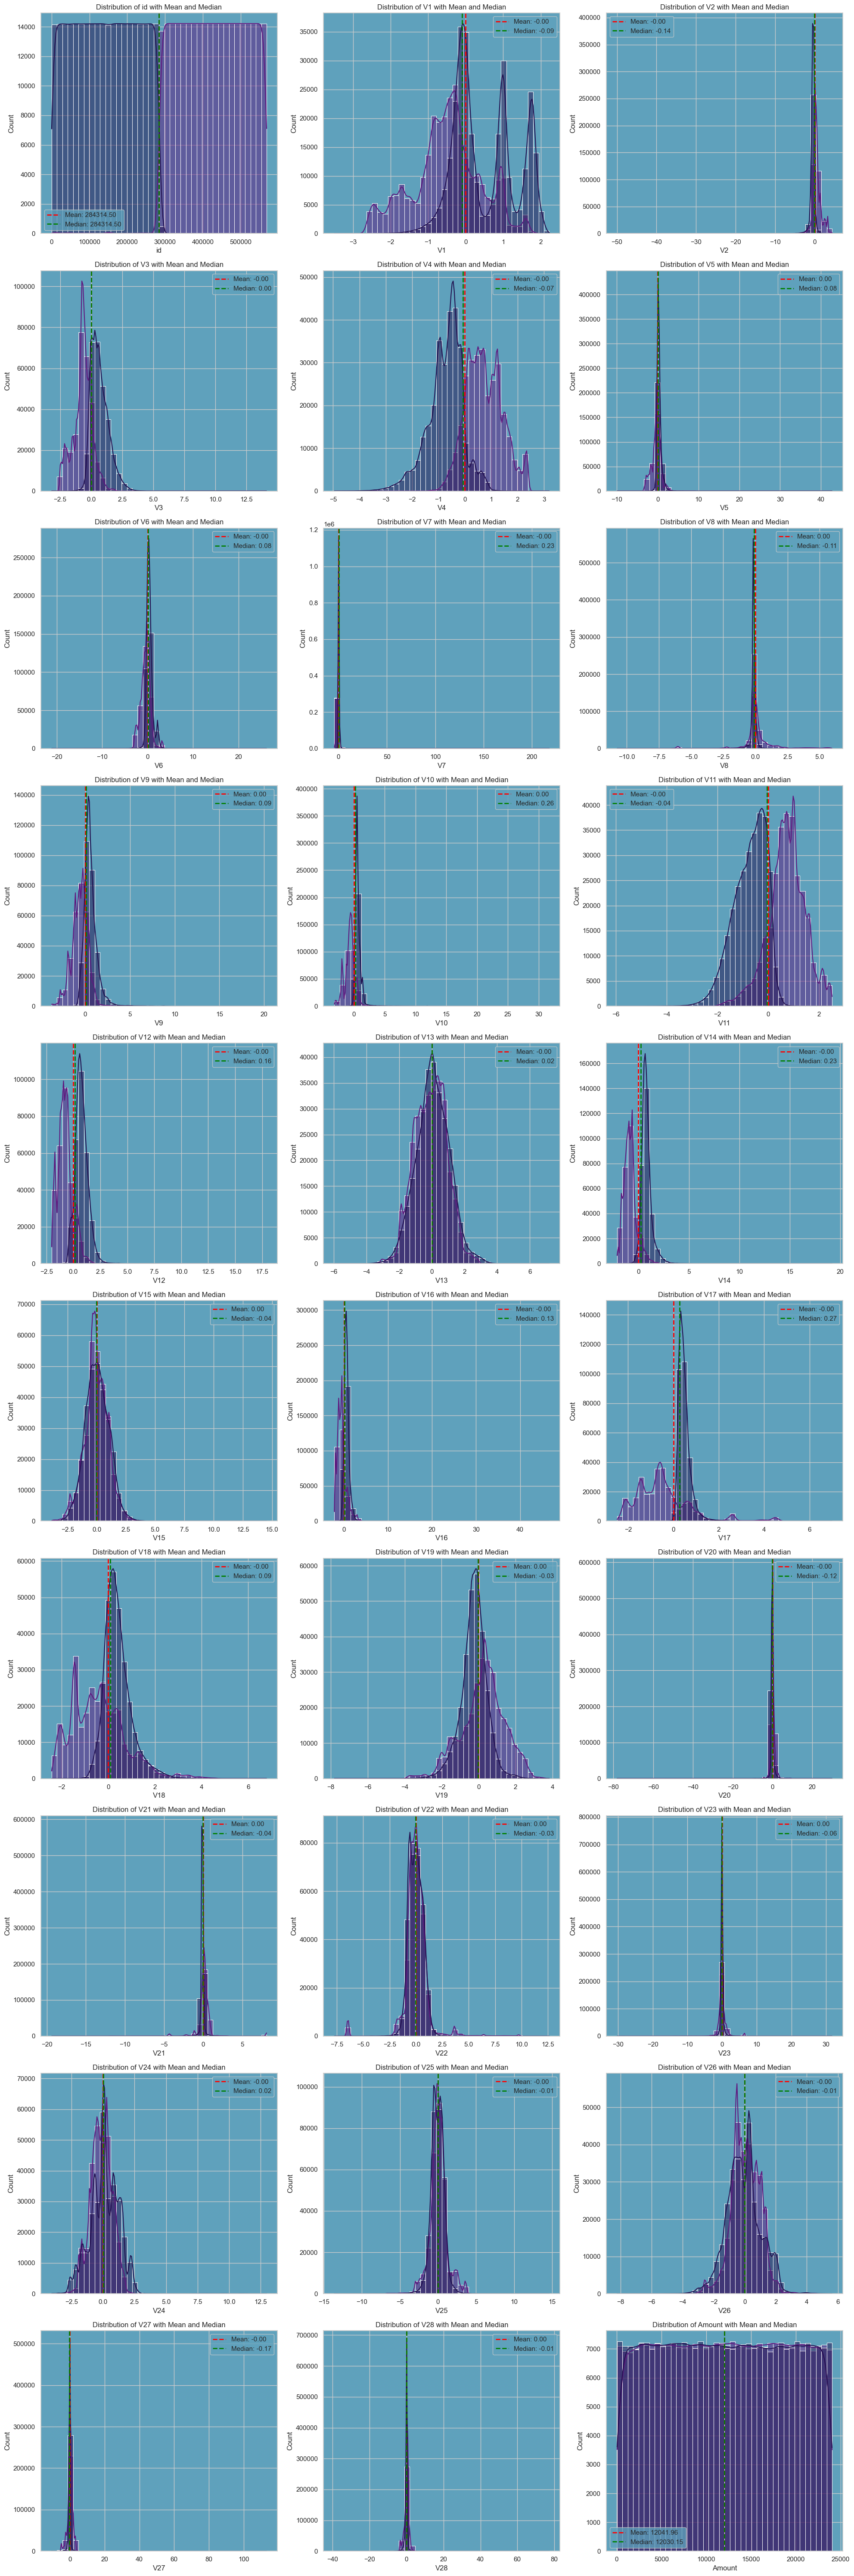

In [4]:
def create_subplots(df, columns, hue, theme_style, theme_rc, palette, figsize=(15, 10)):
    sns.set_theme(style=theme_style, rc=theme_rc)
    
    num_columns = len(columns) - 1  # Exclude the hue column itself
    num_rows = (num_columns + 2) // 3  # Adjust the number of rows based on the number of columns

    fig, axes = plt.subplots(num_rows, 3, figsize=figsize)
    axes = axes.flatten()
    
    plot_index = 0
    for col in columns:
        if col == hue:  # Skip the hue column itself
            continue

        sns.histplot(data=df, x=col, hue=hue, bins=40, palette=palette, edgecolor='white', kde=True, ax=axes[plot_index])
        
        mean_value = df[col].mean()
        median_value = df[col].median()
        
        axes[plot_index].axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_value:.2f}')
        axes[plot_index].axvline(median_value, color='green', linestyle='dashed', linewidth=2, label=f'Median: {median_value:.2f}')
        
        axes[plot_index].set_title(f'Distribution of {col} with Mean and Median')
        axes[plot_index].set_xlabel(col)
        axes[plot_index].set_ylabel('Count')
        axes[plot_index].legend()
        
        plot_index += 1
    
    # Remove extra axes
    for j in range(plot_index, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()

# Example usage
columns = df_tr.columns.to_list()  
palette = sns.color_palette("magma")  # Use the color palette list instead of cmap

create_subplots(df=df_tr, columns=columns, hue='Class', 
                theme_style='whitegrid', theme_rc={"axes.facecolor": "#5fa1bc"}, 
                palette=palette, figsize=(20, 60))

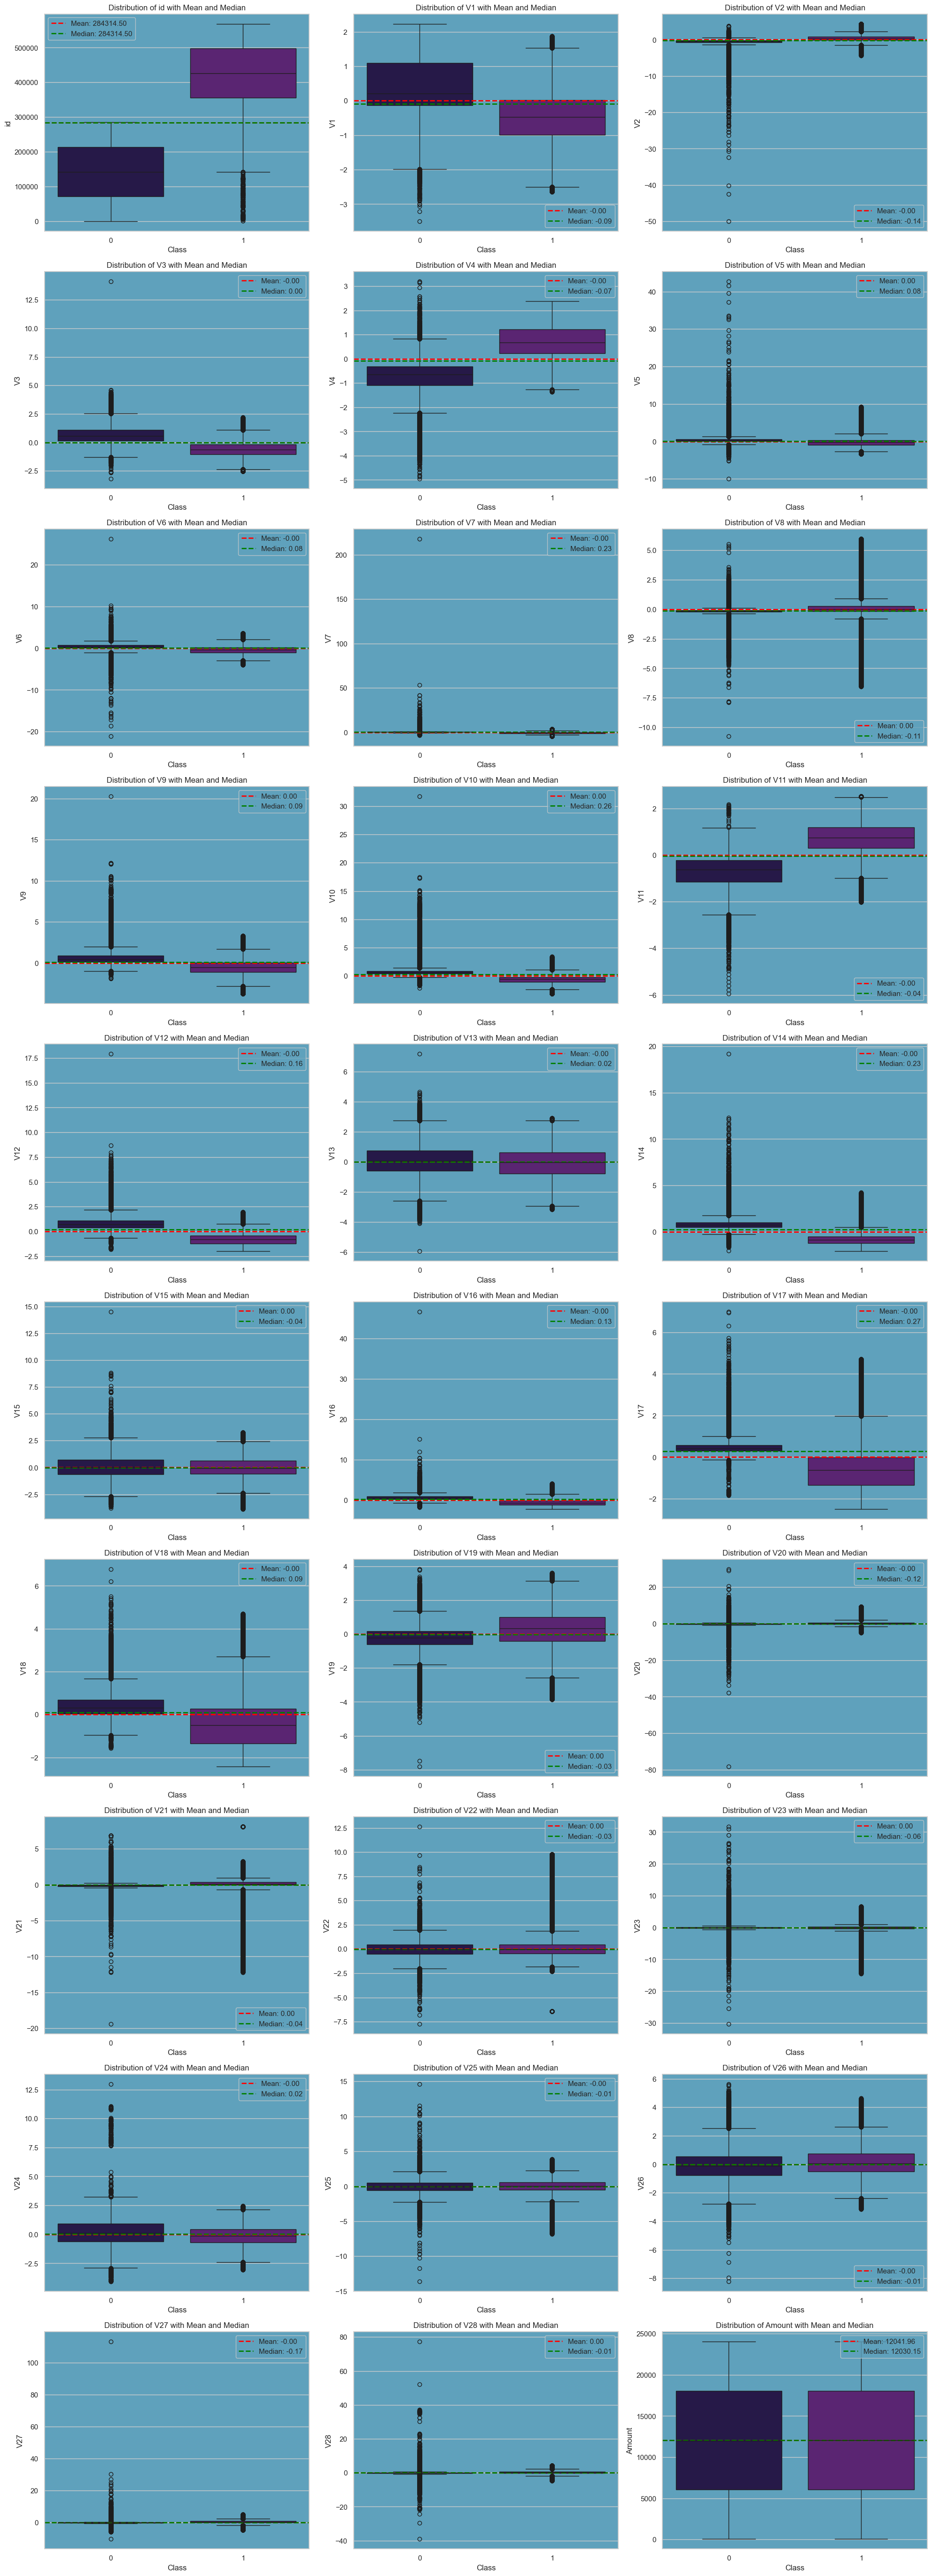

In [5]:
def create_boxplot_subplots(df, columns, hue, theme_style, theme_rc, palette, figsize=(15, 10)):
    sns.set_theme(style=theme_style, rc=theme_rc)
    
    num_columns = len(columns)
    num_rows = (num_columns + 2) // 3  # Adjust the number of rows based on the number of columns

    fig, axes = plt.subplots(num_rows, 3, figsize=figsize)
    axes = axes.flatten()
    
    plot_index = 0
    for col in columns:
        if col == hue:  # Skip the hue column itself
            continue

        sns.boxplot(data=df, x=hue, y=col, palette=palette, ax=axes[plot_index])
        
        mean_value = df[col].mean()
        median_value = df[col].median()
        
        axes[plot_index].axhline(mean_value, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_value:.2f}')
        axes[plot_index].axhline(median_value, color='green', linestyle='dashed', linewidth=2, label=f'Median: {median_value:.2f}')
        
        axes[plot_index].set_title(f'Distribution of {col} with Mean and Median')
        axes[plot_index].set_xlabel(hue)
        axes[plot_index].set_ylabel(col)
        axes[plot_index].legend()
        
        plot_index += 1
    
    # Remove extra axes
    for j in range(plot_index, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()

# Example usage
columns = df_tr.columns.to_list() 
palette = sns.color_palette("magma")  # Use the color palette list instead of cmap

create_boxplot_subplots(df=df_tr, columns=columns, hue='Class', 
                        theme_style='whitegrid', theme_rc={"axes.facecolor": "#5fa1bc"}, 
                        palette=palette, figsize=(20, 60))

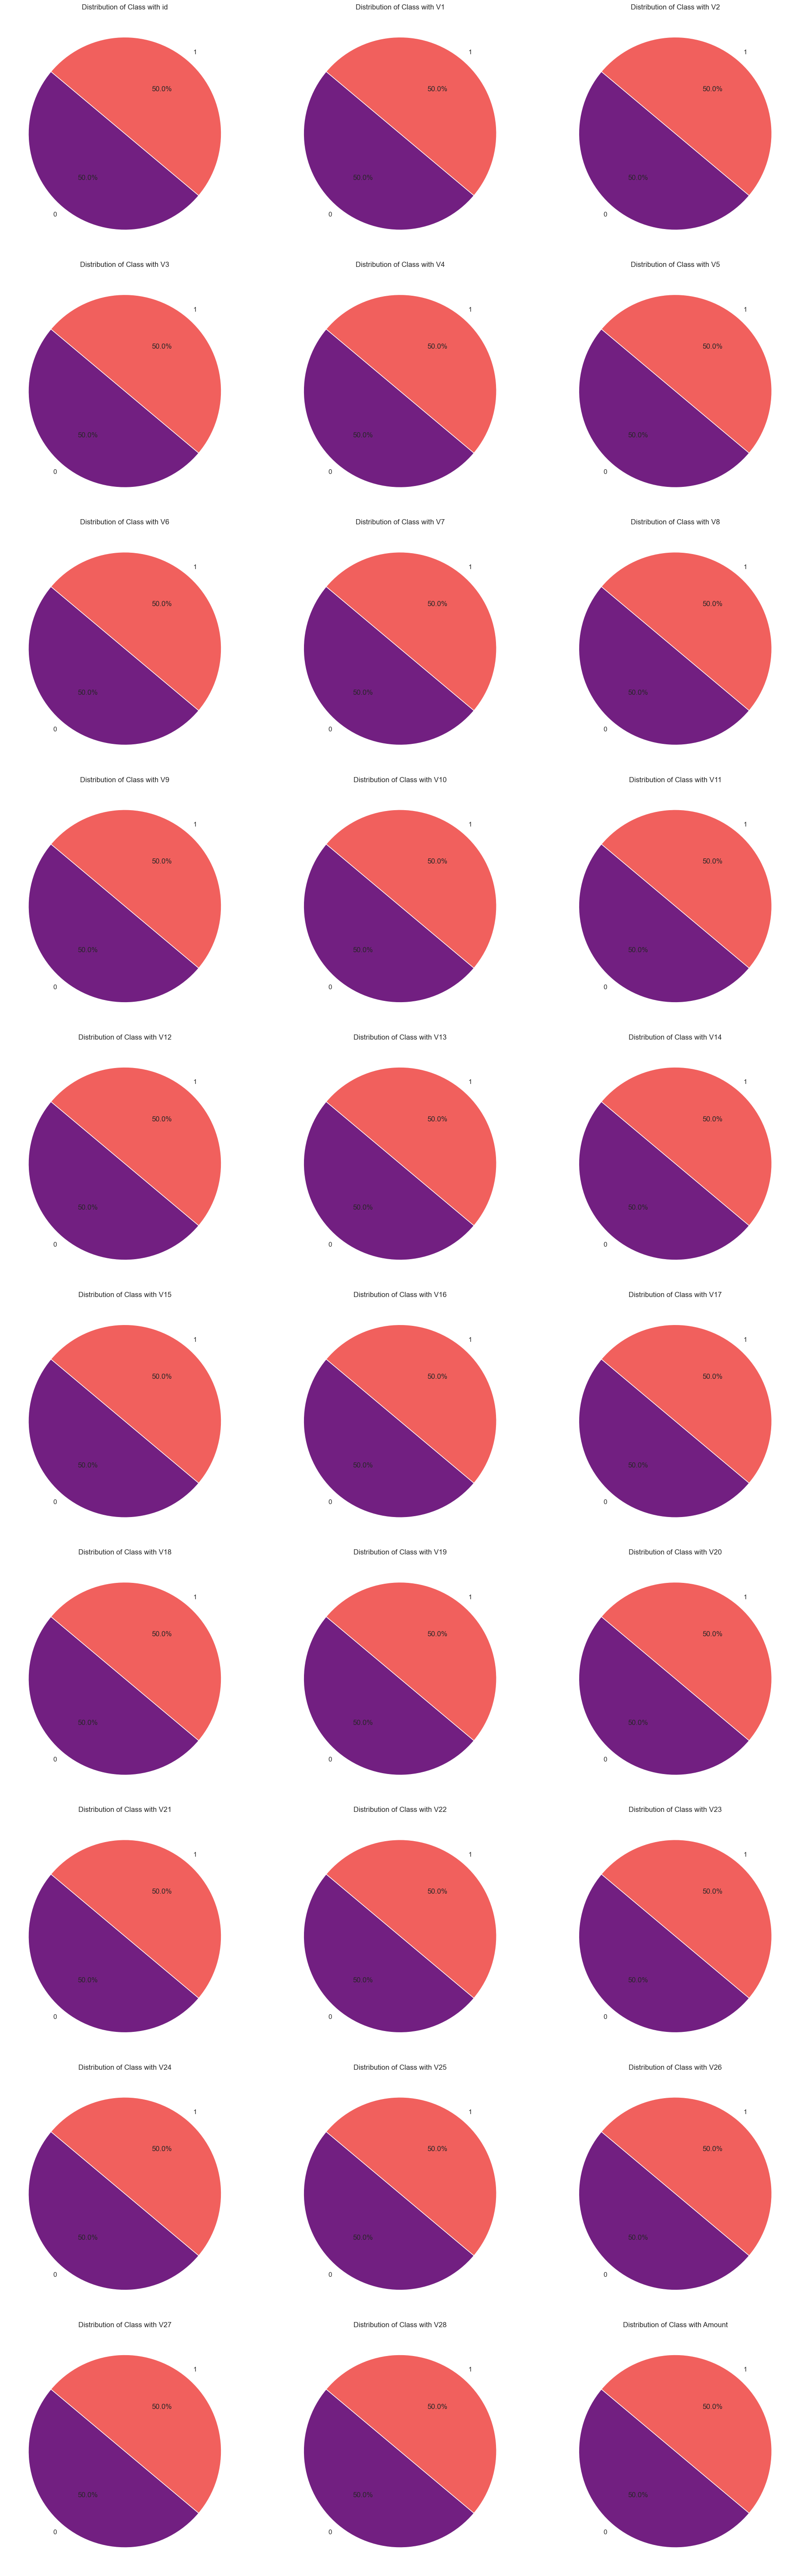

In [6]:
def create_piechart_subplots(df, columns, hue, theme_style, theme_rc, figsize=(15, 10)):
    sns.set_theme(style=theme_style, rc=theme_rc)
    
    # Number of columns excluding the hue column
    num_columns = len(columns) - 1
    num_rows = (num_columns + 2) // 3  # Adjust the number of rows based on the number of columns

    fig, axes = plt.subplots(num_rows, 3, figsize=figsize)
    axes = axes.flatten()
    
    plot_index = 0
    for col in columns:
        if col == hue:  # Skip the hue column itself
            continue

        # Count the occurrences of each class
        class_counts = df[hue].value_counts()

        # Create pie chart
        axes[plot_index].pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette("magma", len(class_counts)))
        axes[plot_index].set_title(f'Distribution of {hue} with {col}')
        plot_index += 1
    
    # Remove extra axes
    for j in range(plot_index, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()

# Example usage
columns = df_tr.columns.to_list() 
hue = columns[-1]  

create_piechart_subplots(df=df_tr, columns=columns, hue=hue, 
                         theme_style='whitegrid', theme_rc={"axes.facecolor": "#5fa1bc"}, 
                         figsize=(20, 60))

In [7]:
# Spliting the data into features and target
X = df_tr.drop('Class', axis=1)
y = df_tr['Class']

# Define numeric features (remove categorical columns)
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Define preprocessing steps
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)])

# Define the model
model = Pipeline(steps=[('preprocessor', preprocessor),
                         ('classifier', CatBoostClassifier(verbose=False))])

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Display classification report with colors and heading
from colorama import Fore, Back, Style
print("\n" + Back.BLUE + Fore.WHITE + "Classification Report" + Style.RESET_ALL)
report = classification_report(y_test, y_pred, output_dict=True)
for key, value in report.items():
    if key in ['0', '1']:  
        color = Fore.GREEN if value['precision'] > 0.8 else Fore.RED
        print(f"Class {key}:")
        print(f"  Precision: {color}{value['precision']:.2f}{Style.RESET_ALL}")
        color = Fore.GREEN if value['recall'] > 0.8 else Fore.RED
        print(f"  Recall: {color}{value['recall']:.2f}{Style.RESET_ALL}")
        color = Fore.GREEN if value['f1-score'] > 0.8 else Fore.RED
        print(f"  F1-score: {color}{value['f1-score']:.2f}{Style.RESET_ALL}")
        print(f"  Support: {value['support']}")
    else:
        print(key + ":", value)

Accuracy: 0.9996570705027874

Classification Report
Class 0:
  Precision: 1.00
  Recall: 1.00
  F1-score: 1.00
  Support: 56750.0
Class 1:
  Precision: 1.00
  Recall: 1.00
  F1-score: 1.00
  Support: 56976.0
accuracy: 0.9996570705027874
macro avg: {'precision': 0.9996569545708367, 'recall': 0.9996571914660413, 'f1-score': 0.9996570692311153, 'support': 113726.0}
weighted avg: {'precision': 0.999657078158671, 'recall': 0.9996570705027874, 'f1-score': 0.9996570705434346, 'support': 113726.0}
